#### Project: SMS Spam Detector

#### Programmer: Ricardo A. Leal

#### Date: 09/26/2020

#### Data collected from Kaggle: SMS Spam Collection Dataset, https://www.kaggle.com/uciml/sms-spam-collection-dataset

#### Skills practiced in this project: Natural language processing, text pre-processing, Embedding, LSTM, GlobalMaxPooling,.


##### Note: 
Some of my features are processed in a similar way to what I have learn on different machine learning courses, books and websites. This is a basic project to get familiar with machine learning techniques.


In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model

#Extensions
%matplotlib inline

#Set seed to reproduce results
tf.random.set_seed(99)


## Get data

In [ ]:
spam_df = pd.read_csv('spam.csv', encoding = 'ISO-8859-1')

## EDA

In [ ]:
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
spam_df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [ ]:
spam_df.columns = ['Target', 'Message']

In [ ]:
spam_df.groupby('Target').describe()

Message                                                               
         count unique                                                top freq
Target                                                                       
ham       4825   4516                             Sorry, I'll call later   30
spam       747    653  Please call our customer service representativ...    4

In [ ]:
spam_df.head()

,Target,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data cleaning

In [ ]:
#Encode categorical labels into numerical labels
spam_df['Target'].replace(to_replace = {'ham': 0, 'spam': 1}, inplace = True)

In [ ]:
spam_df.head()

,Target,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Target   5572 non-null   int64 
 1   Message  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [ ]:
#Split data
X = spam_df['Message'].copy()
y = spam_df['Target'].copy()

In [ ]:
#Convert all characters to lowercase
spam_df['Message'] = spam_df['Message'].str.lower()

##### Remove punctuation:

I will replace all punctuation characters with whitespaces instead of an empty character to avoid creating new words.  

The reason: If I replace punctuation with an empty character, the sentence "Hello,world" would be changed to "Helloworld" instead of "Hello world" 

In [ ]:
'''
Function 'replace_message_punctuation': replaces punctuation characters with whitespaces
'''
def replace_message_punctuation(message):
    for punctuation in string.punctuation:
        message = message.replace(punctuation, ' ')
    return message

In [ ]:
#Replace punctuation
spam_df['Message'] = spam_df['Message'].apply(replace_message_punctuation)

In [ ]:
#Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 555, stratify = y)

In [ ]:
#Tokenize messages
max_num_words = 15000
oov_token = '<UNK>'

#Create tokenizer
tokenizer = Tokenizer(num_words = max_num_words, oov_token = oov_token)
#Fit the train messages
tokenizer.fit_on_texts(X_train)

#Transform both train and test messages
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
#Explore tokens
vocabulary_size = len(tokenizer.word_index)
print("Number of tokens:", vocabulary_size)
print("Word index:", tokenizer.word_index)

Number of tokens: 8039
Word index: {'<UNK>': 1, 'i': 2, 'to': 3, 'you': 4, 'a': 5, 'the': 6, 'u': 7, 'and': 8, 'in': 9, 'is': 10, 'me': 11, 'my': 12, 'for': 13, 'your': 14, 'it': 15, 'of': 16, 'call': 17, 'have': 18, 'on': 19, 'that': 20, '2': 21, 'now': 22, 'are': 23, 'so': 24, 'but': 25, 'not': 26, 'can': 27, 'do': 28, 'or': 29, 'at': 30, 'ur': 31, "i'm": 32, 'get': 33, 'be': 34, 'will': 35, 'with': 36, 'if': 37, 'just': 38, 'no': 39, 'we': 40, 'this': 41, 'gt': 42, 'lt': 43, '4': 44, 'go': 45, 'when': 46, 'up': 47, 'all': 48, 'from': 49, 'ok': 50, 'how': 51, 'what': 52, 'know': 53, 'free': 54, 'out': 55, 'good': 56, 'then': 57, 'like': 58, 'got': 59, 'come': 60, 'was': 61, 'its': 62, 'love': 63, 'day': 64, 'time': 65, 'am': 66, 'only': 67, 'want': 68, 'there': 69, 'send': 70, 'text': 71, 'txt': 72, 'he': 73, 'home': 74, 'as': 75, 'one': 76, 'going': 77, 'r': 78, 'see': 79, 'by': 80, 'need': 81, "i'll": 82, 'about': 83, 'reply': 84, 'lor': 85, 'n': 86, 'stop': 87, 'sorry': 88, 'da': 

In [ ]:
#Add padding to the train set
X_train = pad_sequences(X_train, padding='pre')

#Get lenght of the longest sequence in the train set
maxlen = max(len(message) for message in X_train)

#Add padding to the test set
X_test = pad_sequences(X_test, padding='pre', maxlen = maxlen)

In [ ]:
#Check data before creating the model
#Messages
print("X train shape and data type:", X_train.shape, type(X_train))
print("X test shape and data type:", X_test.shape, type(X_test))

#Targets
print("\ny train shape and data type:", y_train.shape, type(y_train))
print("y test shape and data type:", y_test.shape, type(y_test))

X train shape and data type: (4457, 189) <class 'numpy.ndarray'>
X test shape and data type: (1115, 189) <class 'numpy.ndarray'>

y train shape and data type: (4457,) <class 'pandas.core.series.Series'>
y test shape and data type: (1115,) <class 'pandas.core.series.Series'>


In [ ]:
#Convert targets to numpy array to match the message data type

y_train = y_train.to_numpy()
print("y train data type:",type(y_train))

y_test = y_test.to_numpy()
print("y test data type:", type(y_test))

y train data type: <class 'numpy.ndarray'>
y test data type: <class 'numpy.ndarray'>


## Create model

In [ ]:
#Create model

D = 15

i = Input(shape = (maxlen,))
x = Embedding(input_dim = (vocabulary_size + 1), output_dim = D, input_length = maxlen)(i)
x = LSTM(25, return_sequences = True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(100, activation = 'relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation = 'sigmoid')(x)

#Model
model = Model(i, output)

In [ ]:
#Check summary
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 189)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 189, 15)           120600    
_________________________________________________________________
lstm (LSTM)                  (None, 189, 25)           4100      
_________________________________________________________________
global_max_pooling1d (Global (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               2600      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
#Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
#Create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 666, stratify = y_train)

## Train model

In [ ]:
#Train model
history = model.fit(X_train, y_train, epochs = 7, validation_data = (X_val, y_val))

Epoch 1/7
119/119 [==============================] - 10s 81ms/step - loss: 0.4327 - accuracy: 0.8646 - val_loss: 0.3751 - val_accuracy: 0.8655
Epoch 2/7
119/119 [==============================] - 9s 77ms/step - loss: 0.1915 - accuracy: 0.9269 - val_loss: 0.0980 - val_accuracy: 0.9761
Epoch 3/7
119/119 [==============================] - 9s 78ms/step - loss: 0.0377 - accuracy: 0.9923 - val_loss: 0.0791 - val_accuracy: 0.9821
Epoch 4/7
119/119 [==============================] - 9s 77ms/step - loss: 0.0144 - accuracy: 0.9966 - val_loss: 0.0902 - val_accuracy: 0.9821
Epoch 5/7
119/119 [==============================] - 9s 77ms/step - loss: 0.0088 - accuracy: 0.9976 - val_loss: 0.0758 - val_accuracy: 0.9776
Epoch 6/7
119/119 [==============================] - 9s 77ms/step - loss: 0.0051 - accuracy: 0.9992 - val_loss: 0.0793 - val_accuracy: 0.9806
Epoch 7/7
119/119 [==============================] - 9s 77ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.1009 - val_accuracy: 0.9806


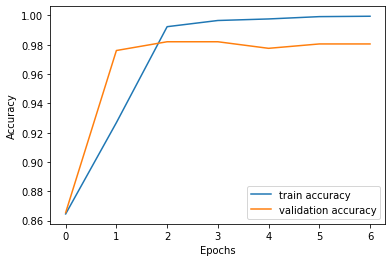

In [ ]:
#Plot accuracy
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc = 'lower right')

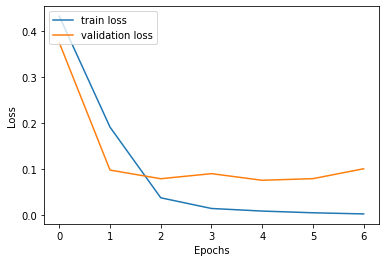

In [ ]:
#Plot loss
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc = 'upper left')

## Prediction

In [ ]:
predictions = model.predict(X_test)

## Check performance

In [ ]:
model.evaluate(X_test, y_test)

35/35 [==============================] - 1s 15ms/step - loss: 0.0681 - accuracy: 0.9883


[0.0681028664112091, 0.9883407950401306]

In [ ]:
#Convert prediction probabilities to labels using a 0.5 threshold
prediction_labels = [0 if x < 0.5 else 1 for x in predictions]


Confusion matrix:



(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

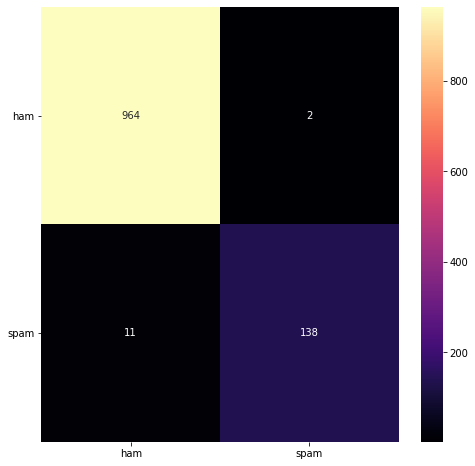

In [ ]:
#Create a confusion matrix with the results from the predictions
target_labels = ['ham', 'spam']

print("\nConfusion matrix:\n")
plt.figure(figsize = (8,8))
sns.heatmap(confusion_matrix(y_test, prediction_labels), annot = True, fmt='d', cmap = 'magma', xticklabels = target_labels, yticklabels = target_labels)
plt.yticks(rotation = 0) 

In [ ]:
#Classification report
print(classification_report(y_test, prediction_labels, target_names = target_labels, digits = 3))

              precision    recall  f1-score   support

         ham      0.989     0.998     0.993       966
        spam      0.986     0.926     0.955       149

    accuracy                          0.988      1115
   macro avg      0.987     0.962     0.974      1115
weighted avg      0.988     0.988     0.988      1115



## Improve performance

With a 0.5 threshold, the model classified 16 spam messages as ham. Also, the model classified 3 ham messages as spam. But for a spam detector, I think it is better to have less spams classified as ham and only a few ham messages classified as spam. 

To improve the classification, I will find explore F1 scores using different thresholds to decrease the number of spam messages classified as ham. I think having less spam classified as ham is better for a spam detector

In [ ]:
#Find the best threshold given the best F1 score
thresholds = []
scores = []

#Loop to get the scores
for threshold in range(0, 101, 1):
  thresholds.append(threshold/100)
  prediction_labels = [0 if x < (threshold/100) else 1 for x in predictions]
  scores.append(f1_score(y_test, prediction_labels))

#Get best threshold
best_threshold = thresholds[scores.index(max(scores))]
print("A threshold of", best_threshold, " gives the best F1 score:", max(scores), "\n")

A threshold of 0.07  gives the best F1 score: 0.9621993127147765 



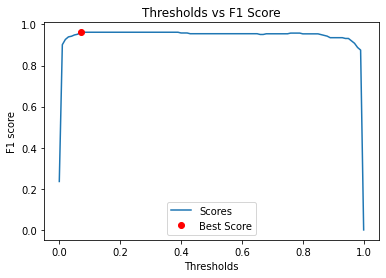

In [ ]:
#Plot thresholds vs F1 Score

plt.title("Thresholds vs F1 Score")
plt.xlabel("Thresholds")
plt.ylabel("F1 score")
plt.plot(thresholds, scores,  label = 'Scores')
plt.plot(best_threshold, max(scores), 'ro', label = 'Best Score')
plt.legend(loc = 'lower center')

In [ ]:
#Convert prediction probabilities to labels with the best threshold
prediction_labels = [0 if x < best_threshold else 1 for x in predictions]


Confusion matrix:



(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

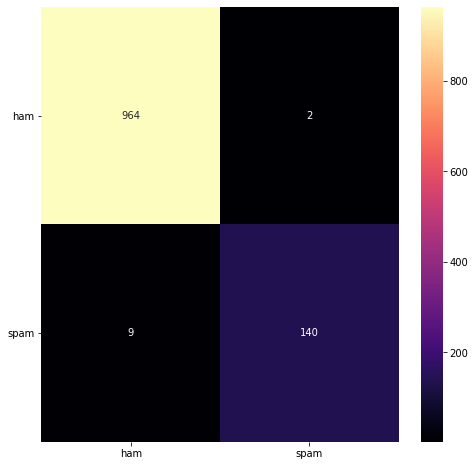

In [ ]:
#Create a confusion matrix with the results from the predictions
target_labels = ['ham', 'spam']

print("\nConfusion matrix:\n")
plt.figure(figsize = (8,8))
sns.heatmap(confusion_matrix(y_test, prediction_labels), annot = True, fmt='d', cmap = 'magma', xticklabels = target_labels, yticklabels = target_labels)
plt.yticks(rotation = 0) 

In [ ]:
#Classification report
print(classification_report(y_test, prediction_labels, target_names = target_labels, digits = 3))

              precision    recall  f1-score   support

         ham      0.991     0.998     0.994       966
        spam      0.986     0.940     0.962       149

    accuracy                          0.990      1115
   macro avg      0.988     0.969     0.978      1115
weighted avg      0.990     0.990     0.990      1115

